In [1]:
import os, sys
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2


from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.utils import Sequence
from keras.utils import to_categorical

from sklearn.utils import class_weight, shuffle
from sklearn.metrics import f1_score, fbeta_score
from sklearn.model_selection import train_test_split

import tensorflow as tf

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 224
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = -1 # use 1000 when you just want to explore new idea, use -1 for full train

# Reading Data

In [2]:
df_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
df_train["data_augm"] = np.nan
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
display(df_train.head())
display(df_test.head())

id_code  diagnosis  data_augm
0  000c1434d8d7          2        NaN
1  001639a390f0          4        NaN
2  0024cdab0c1e          1        NaN
3  002c21358ce6          0        NaN
4  005b95c28852          0        NaN

id_code
0  0005cfc8afb6
1  003f0afdcd15
2  006efc72b638
3  00836aaacf06
4  009245722fa4

In [3]:
x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=SEED)

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

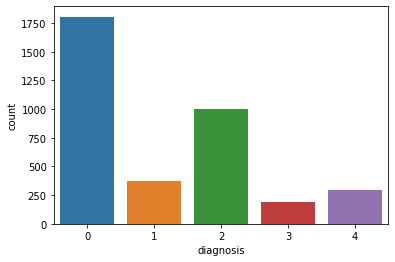

In [4]:
import seaborn as sns
sns.countplot("diagnosis",data= df_train)

# Data Augmentation

Since the number of images in each class are unequal, we apply data augmentation techniques likke rotating, flipping andzooming of images to make the number of images in each class equal.
Unequal number of images in classes can result in a biased trained NN.

(to be done on training data)

In [5]:
DATA_AUGM = False
DATA_AUGM_FACTOR = 1
PATH_AUGM = '/kaggle/working/train_augm_images/'
RANDOM_STATE = 77

In [6]:
HEIGHT = 224
WIDTH = 224

def openImage(row, train=True, resize=False):
    image = None
    #print(row.img_name)
    #print(row.data_augm)
    if not train:
        image = cv2.imread('../input/aptos2019-blindness-detection/test_images/{}.png'.format(row.id_code))
    elif not pd.isnull(row.data_augm):
        #print("HELLO2")
        image = cv2.imread(row.data_augm)
    elif not pd.isnull(row.id_code):
        #print("HELLO3")
        image = cv2.imread('../input/aptos2019-blindness-detection/train_images/{}.png'.format(row.id_code))
    else:
        print("[Error] Could not open the image. Log: {}".format(row))
    if resize and not image is None:
        return cv2.resize(image, (WIDTH, HEIGHT))
    return image

In [7]:
if DATA_AUGM:
    shutil.rmtree(PATH_AUGM, ignore_errors=True, onerror=None)
    shutil.os.mkdir(PATH_AUGM)
    df_train = shuffle(df_train, random_state=RANDOM_STATE)
    display(df_train.head())
    max_size = int(df_train.diagnosis.value_counts().max() * DATA_AUGM_FACTOR)
    for diag in range(5):
        shutil.rmtree('{}diag_{}'.format(PATH_AUGM, diag), ignore_errors=True, onerror=None)
        shutil.os.mkdir('{}diag_{}'.format(PATH_AUGM, diag))
        diag_df = df_train[df_train.diagnosis == diag]
        display(diag_df.head())
        size = len(diag_df)
        print(diag, " " , size)
        to_create = max_size - size
        augm_per_img = max(to_create // size, 1)
        while to_create > 0:
            for row in diag_df.itertuples():
                if to_create < 0:
                    break
                
                image = np.expand_dims(cv2.cvtColor(openImage(row, resize=True), cv2.COLOR_BGR2RGB), 0)
                data_generator = ImageDataGenerator(rotation_range=360, vertical_flip=True, horizontal_flip=True, zoom_range=0.1)
                data_generator.fit(image)
                id_code = row.id_code
                for x, val in zip(data_generator.flow(image, save_to_dir='{}diag_{}'.format(PATH_AUGM, diag), 
                                                      save_prefix=id_code, save_format='png'), 
                                  range(augm_per_img - 1)):
                    pass
                to_create -= augm_per_img
    for diag in range(5):
        images = np.array(os.listdir("{}diag_{}".format(PATH_AUGM, diag)))
        for image in images:#	img_name	diagnosis	data_augm
            df_train = df_train.append(pd.DataFrame([[np.nan, diag, "{}diag_{}/{}".format(PATH_AUGM, diag, image)]], 
                                                    columns=df_train.columns), ignore_index = True)
    df_train = shuffle(df_train, random_state=RANDOM_STATE)

         id_code  diagnosis  data_augm
0   000c1434d8d7          2        NaN
1   001639a390f0          4        NaN
2   0024cdab0c1e          1        NaN
3   002c21358ce6          0        NaN
4   005b95c28852          0        NaN
5   0083ee8054ee          4        NaN
6   0097f532ac9f          0        NaN
7   00a8624548a9          2        NaN
8   00b74780d31d          2        NaN
9   00cb6555d108          1        NaN
10  00cc2b75cddd          0        NaN
11  00e4ddff966a          2        NaN
12  00f6c1be5a33          0        NaN
13  0104b032c141          3        NaN
14  0124dffecf29          1        NaN
15  0125fbd2e791          0        NaN
16  012a242ac6ff          2        NaN
17  014508ccb9cb          0        NaN
18  0151781fe50b          0        NaN
19  0161338f53cc          2        NaN
len : 
3662


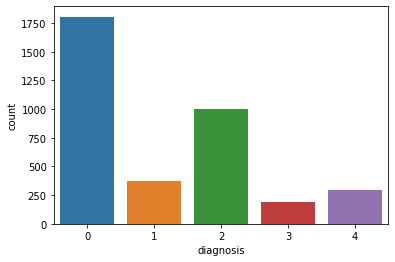

In [8]:
print(df_train.head(20))
sns.countplot("diagnosis",data= df_train)
print("len : ")
print(len(df_train))

# Data Preprocessing

<class 'numpy.ndarray'>
(2136, 3216, 3)
<class 'tuple'>


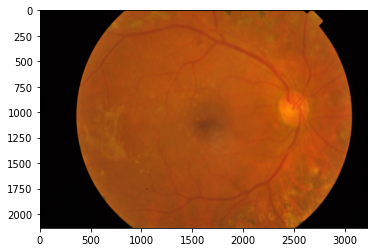

In [9]:
# checking image details
im = cv2.imread('../input/aptos2019-blindness-detection/train_images/001639a390f0.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

print(type(im))
print(im.shape)
print(type(im.shape))

<class 'numpy.ndarray'>
(224, 224, 3)
<class 'tuple'>


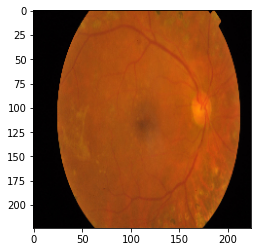

In [10]:
# resizing it to 512 * 512
im = cv2.resize(im, (WIDTH, HEIGHT))
plt.imshow(im)
print(type(im))
print(im.shape)
print(type(im.shape))

First let's see the original input.

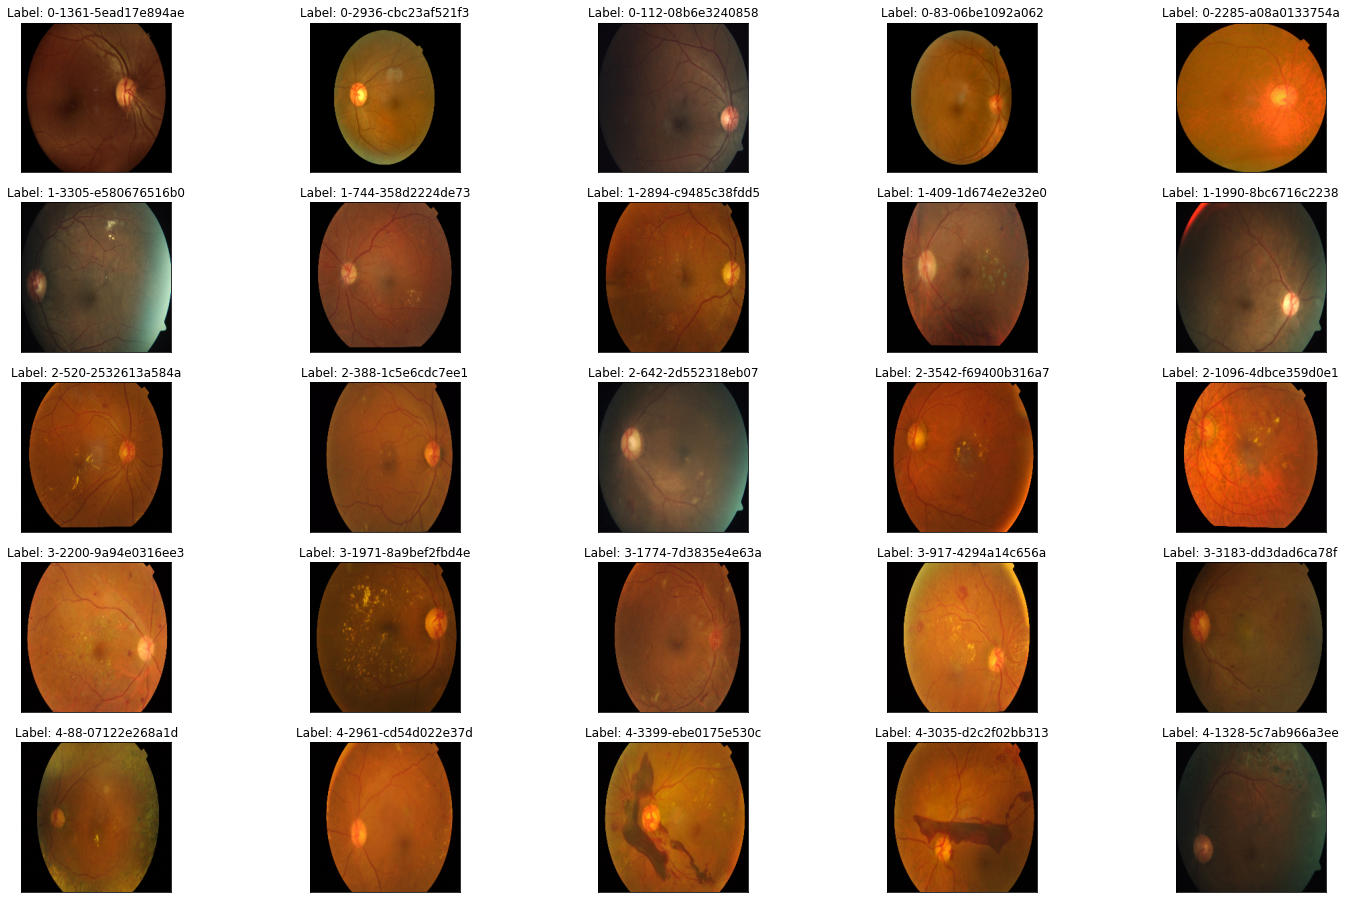

In [11]:
df_preprocess = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')

fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in range(5):
    for i, (idx, row) in enumerate(df_preprocess.loc[df_preprocess['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        
        path = ""
        id = ""
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        id = row.id_code
        
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (WIDTH, HEIGHT))

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, id) )        

We can see two problems which make the severity difficult to spot on. First, some images are very dark [pic(0,2) and pic(4,4) ] and sometimes different color illumination is confusing [pic (3,3)]. Second, we can get the uninformative dark areas for some pictures [pic(0,1), pic(0,3)]. This is important when we reduce the picture size, as informative areas become too small. So it is intuitive to crop the uninformative areas out in the second case.

We can try gray scale and feel understand better for some pictures, as color distraction is gone. For example, we can see more blood clearer in the upper part of pic(4,4), which has severity of level 4.

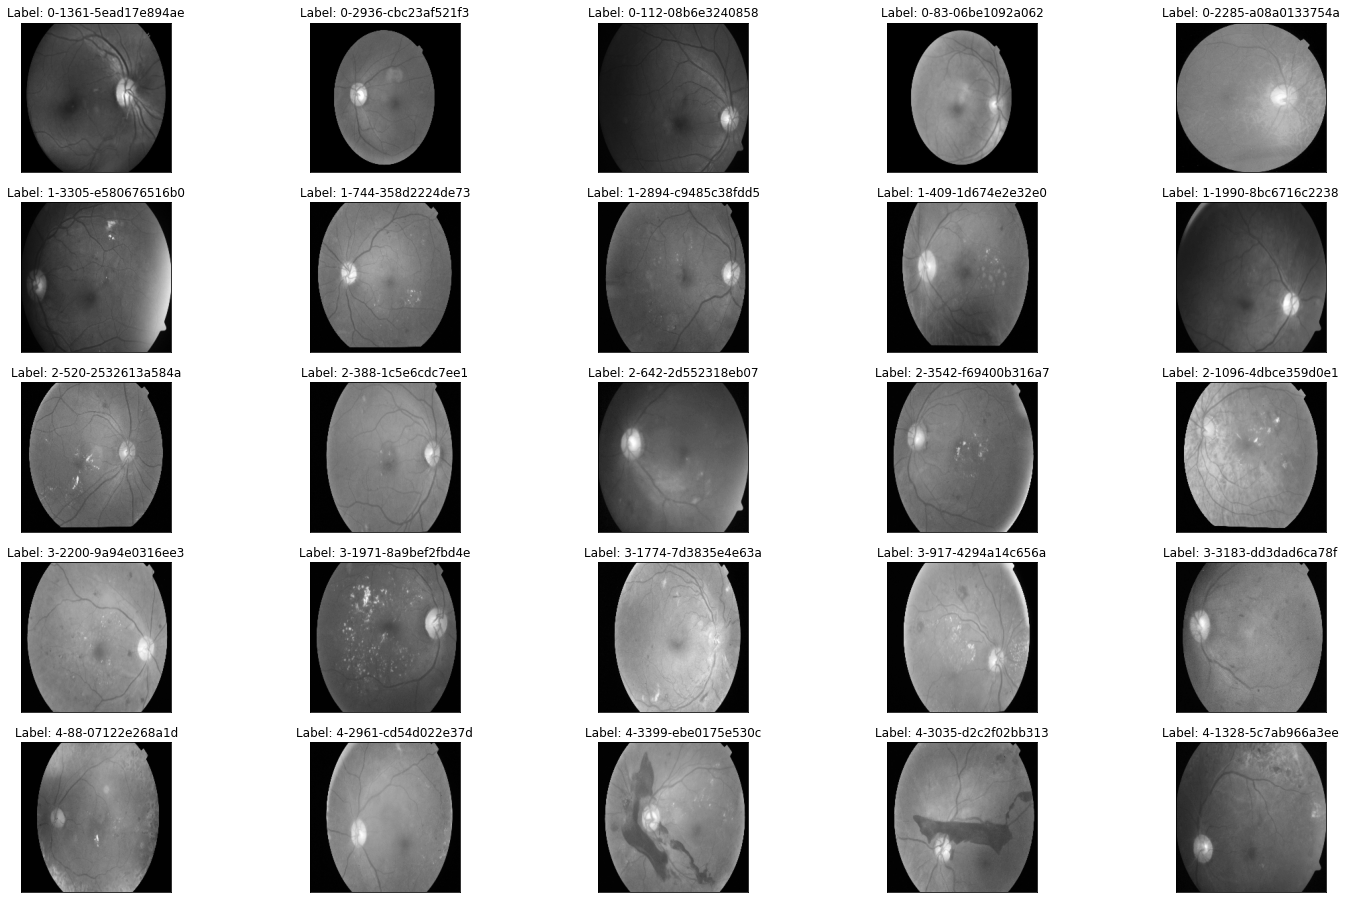

In [12]:
fig = plt.figure(figsize=(25, 16))
for class_id in range(5):
    for i, (idx, row) in enumerate(df_preprocess.loc[df_preprocess['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

For severity level 4, I feel that two examples here are difficult to spot on, pic(4,1) and pic(4,4). As we try zooming to see the details (use real size image), we can see some abnormalities (cotton wool spots or hard exudates ?) in those eyes clearer (observe the lower-right part of the eye). Therefore, IMG_SIZE is definitely important for this problem. In the next section, we shall see better method than gray-scale conversion.

2136 3216


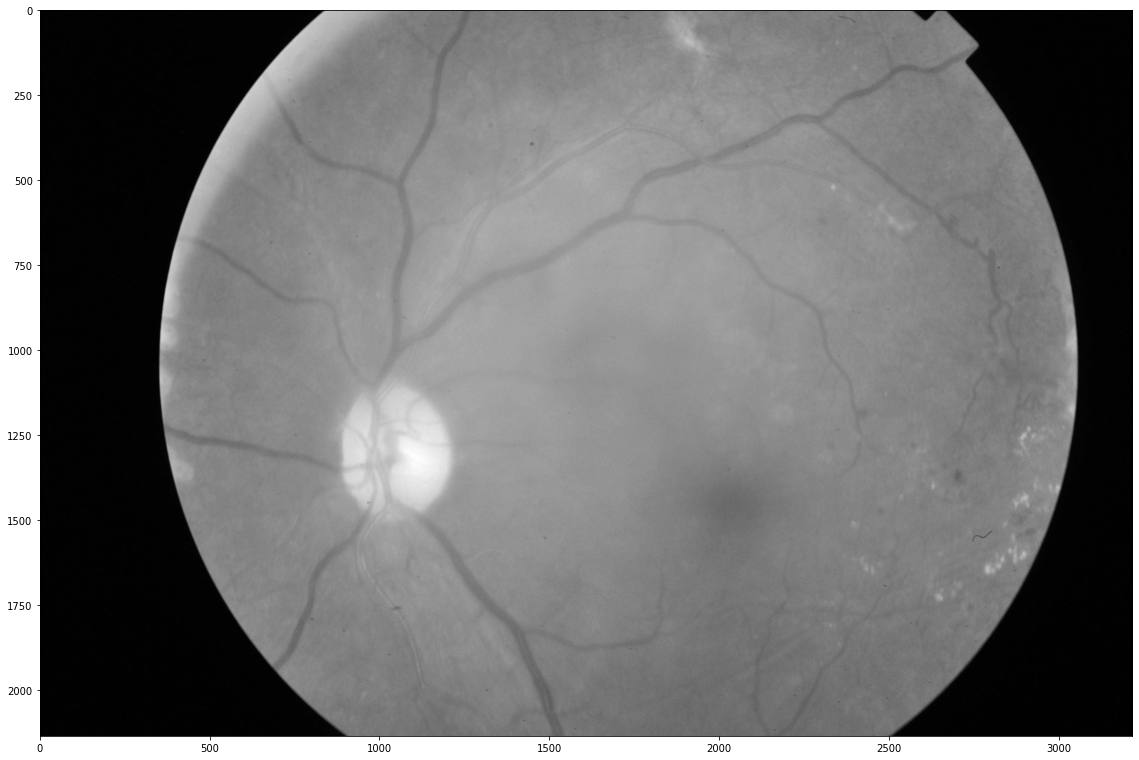

In [13]:
dpi = 80 #inch

path=f"../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png" # lower-right, this still looks not so severe, can be class3
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
height, width = image.shape
print(height, width)

SCALE=2
figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE

fig = plt.figure(figsize=figsize)
plt.imshow(image, cmap='gray')

## Improving Lighting condition in images

We can blend the image with its gaussian blurred image with weights as 4 and -4

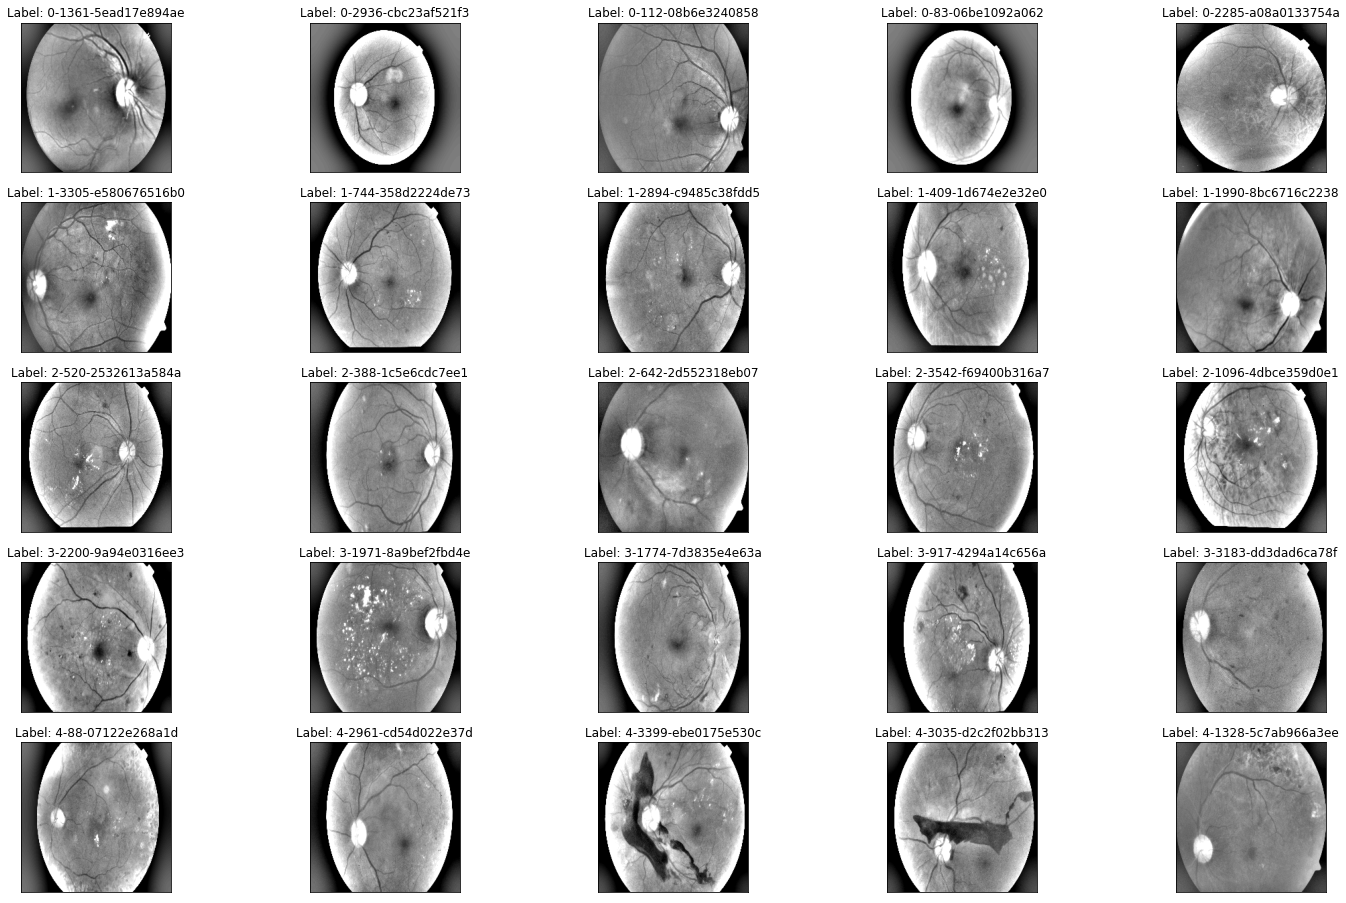

In [14]:
fig = plt.figure(figsize=(25, 16))
for class_id in range(5):
    for i, (idx, row) in enumerate(df_preprocess.loc[df_preprocess['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

As we can see now image [4,4] is not as dark as earlier in the normal grayscale image.

We can further improve the preprocessing process by auto-cropping the images to remove unwanted black borders. Also colored images with light blending can have great results. So let's apply light blending with auto cropping on colored images itself.

In [15]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [16]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

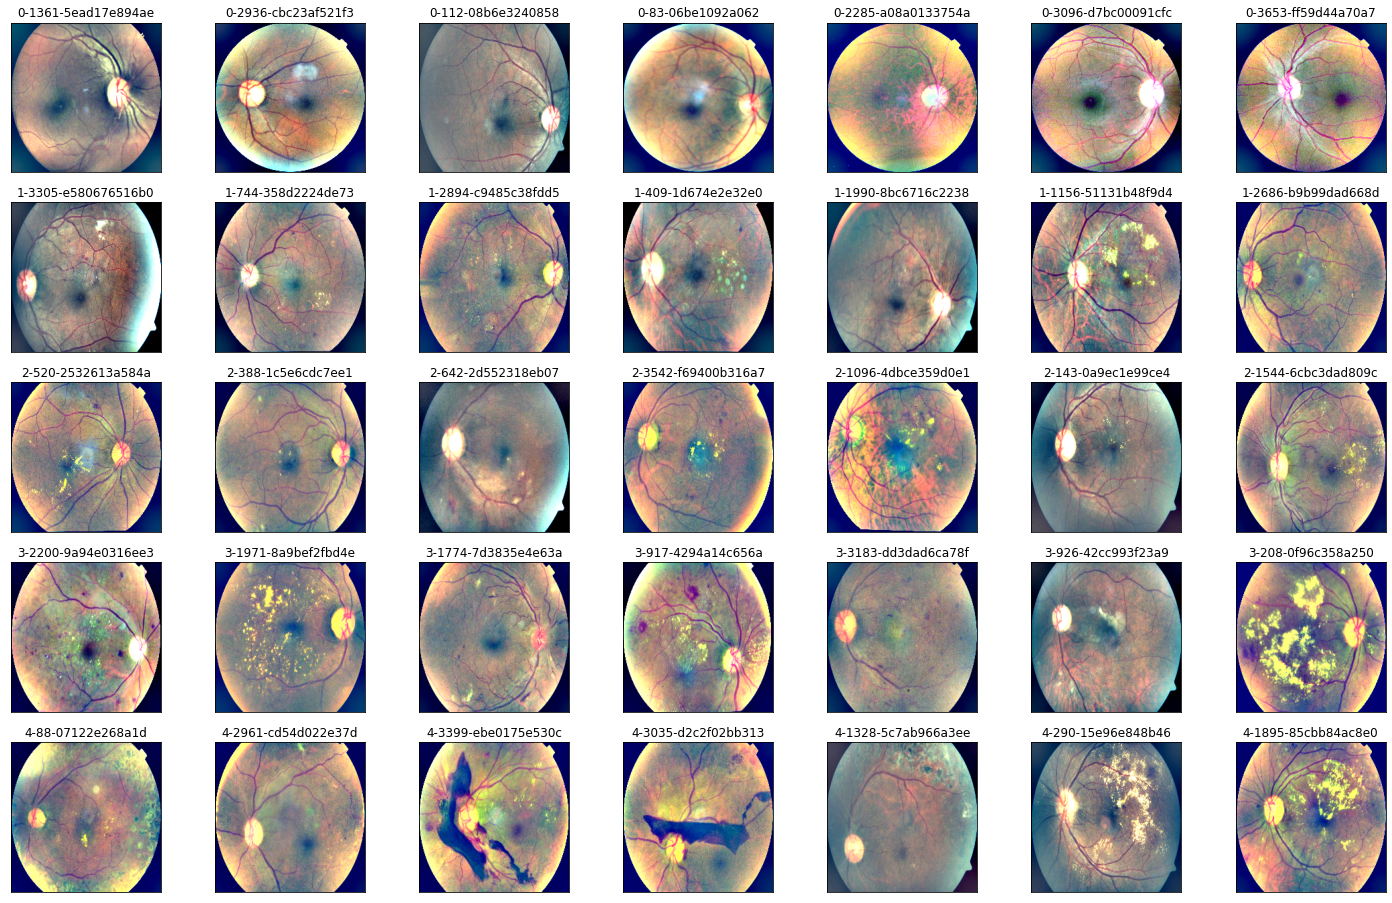

In [17]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in range(5):
    for i, (idx, row) in enumerate(df_preprocess.loc[df_preprocess['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = load_ben_color(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )

One more method of cropping is CIRCLE CROP

In [18]:
def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    img=cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    return img 

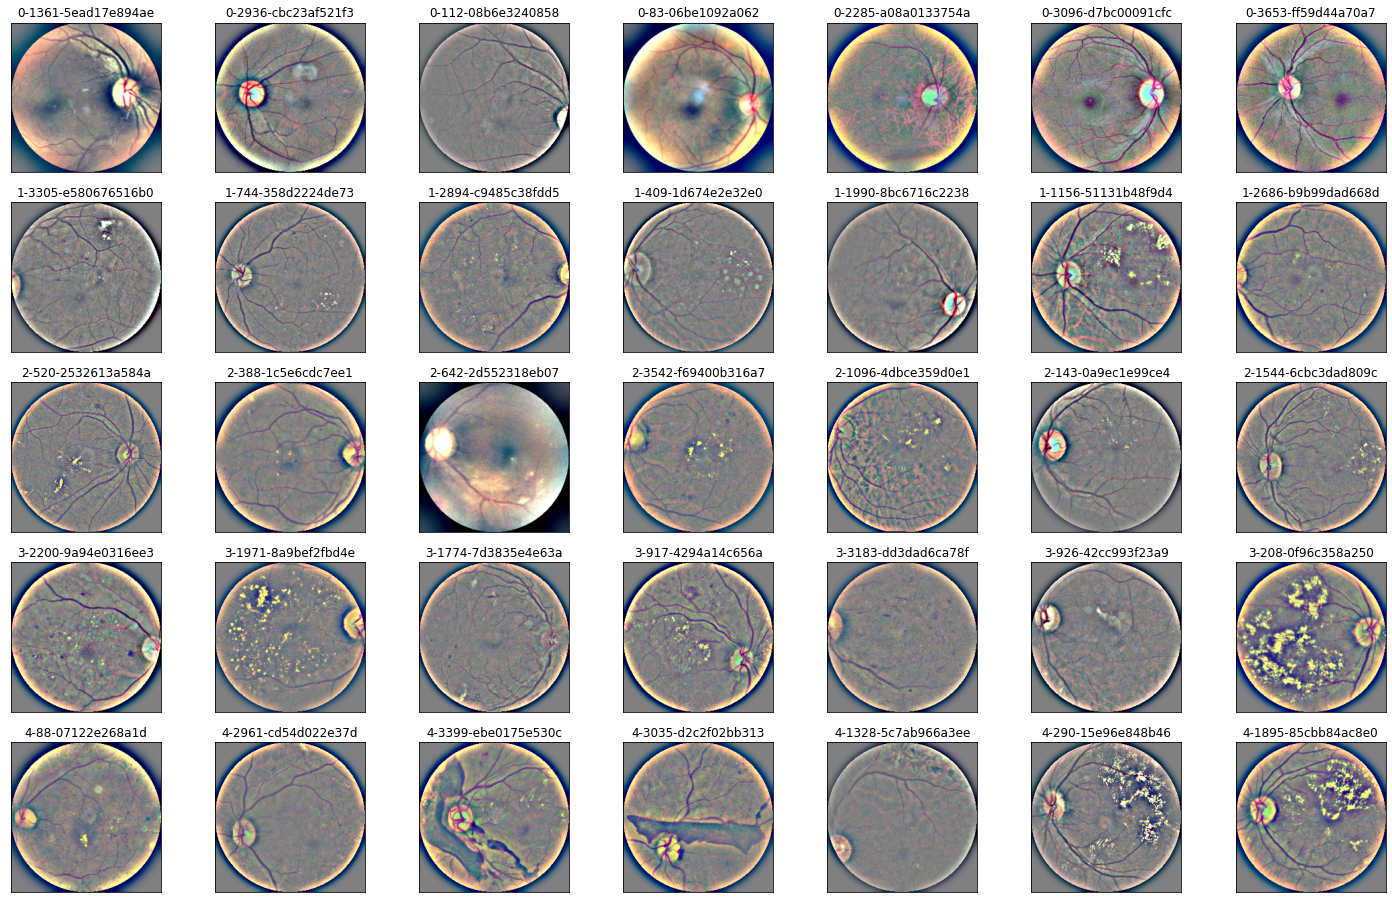

In [19]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in range(5):
    for i, (idx, row) in enumerate(df_preprocess.loc[df_preprocess['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = circle_crop(path,sigmaX=50)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )

We can try plotting a picture (sample train pic(4,1) above) with IMG_SIZE with cropping, now important information is much clearer to see with sigmaX = 10


224 224


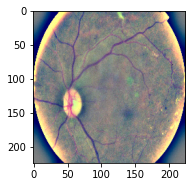

In [20]:
dpi = 80 #inch

# path=f"../input/aptos2019-blindness-detection/train_images/5c7ab966a3ee.png" # notice upper part
path=f"../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png" # lower-right, can be class3
image = load_ben_color(path,sigmaX=10)

height, width = HEIGHT, WIDTH
print(height, width)

SCALE=1
figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE

fig = plt.figure(figsize=figsize)
plt.imshow(image, cmap='gray')

224 224


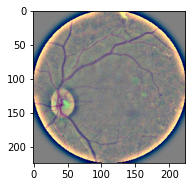

In [21]:
dpi = 80 #inch

# path=f"../input/aptos2019-blindness-detection/train_images/5c7ab966a3ee.png" # notice upper part
path=f"../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png" # lower-right, can be class3
image = circle_crop(path,sigmaX=50)

height, width = HEIGHT, WIDTH
print(height, width)

SCALE=1
figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE

fig = plt.figure(figsize=figsize)
plt.imshow(image, cmap='gray')

# Training

We use densenet 121 on two types of preprocessed images : 
1. simple light blending with auto crop
2. cicular crop

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

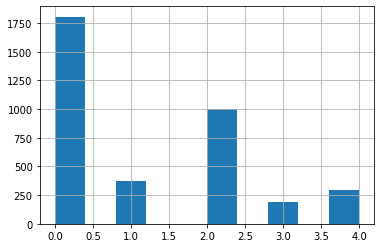

In [22]:
df_train['diagnosis'].hist()
df_train['diagnosis'].value_counts()

In [33]:
# Miscelaneous.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as t
import cv2
import warnings
import shutil
import os
import os.path
from os import path

# Sklearn utils.
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

# Keras.
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications import DenseNet169, DenseNet121
from keras.utils import Sequence
from keras import layers
from keras.layers import Dense, Dropout, Flatten, Input, ZeroPadding2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import optimizers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

3662


id_code  diagnosis  data_augm  \
0  000c1434d8d7          2        NaN   
1  001639a390f0          4        NaN   
2  0024cdab0c1e          1        NaN   
3  002c21358ce6          0        NaN   
4  005b95c28852          0        NaN   
5  0083ee8054ee          4        NaN   
6  0097f532ac9f          0        NaN   
7  00a8624548a9          2        NaN   
8  00b74780d31d          2        NaN   
9  00cb6555d108          1        NaN   

                                                path  
0  /kaggle/input/aptos2019-blindness-detection/tr...  
1  /kaggle/input/aptos2019-blindness-detection/tr...  
2  /kaggle/input/aptos2019-blindness-detection/tr...  
3  /kaggle/input/aptos2019-blindness-detection/tr...  
4  /kaggle/input/aptos2019-blindness-detection/tr...  
5  /kaggle/input/aptos2019-blindness-detection/tr...  
6  /kaggle/input/aptos2019-blindness-detection/tr...  
7  /kaggle/input/aptos2019-blindness-detection/tr...  
8  /kaggle/input/aptos2019-blindness-detection/tr...  
9  /kaggle/input/aptos2019-blindness-detection/tr...

           id_code  diagnosis  data_augm  \
0     000c1434d8d7          2        NaN   
1     001639a390f0          4        NaN   
2     0024cdab0c1e          1        NaN   
3     002c21358ce6          0        NaN   
4     005b95c28852          0        NaN   
...            ...        ...        ...   
3657  ffa47f6a7bf4          2        NaN   
3658  ffc04fed30e6          0        NaN   
3659  ffcf7b45f213          2        NaN   
3660  ffd97f8cd5aa          0        NaN   
3661  ffec9a18a3ce          2        NaN   

                                                   path  
0     /kaggle/input/aptos2019-blindness-detection/tr...  
1     /kaggle/input/aptos2019-blindness-detection/tr...  
2     /kaggle/input/aptos2019-blindness-detection/tr...  
3     /kaggle/input/aptos2019-blindness-detection/tr...  
4     /kaggle/input/aptos2019-blindness-detection/tr...  
...                                                 ...  
3657  /kaggle/input/aptos2019-blindness-detection/tr...  
3658  /

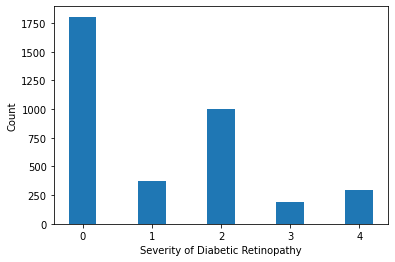

3662


id_code  diagnosis data_augm                       path
0  000c1434d8d7          2       nan  /kaggle/working/ben/0.png
1  001639a390f0          4       nan  /kaggle/working/ben/1.png
2  0024cdab0c1e          1       nan  /kaggle/working/ben/2.png
3  002c21358ce6          0       nan  /kaggle/working/ben/3.png
4  005b95c28852          0       nan  /kaggle/working/ben/4.png
5  0083ee8054ee          4       nan  /kaggle/working/ben/5.png
6  0097f532ac9f          0       nan  /kaggle/working/ben/6.png
7  00a8624548a9          2       nan  /kaggle/working/ben/7.png
8  00b74780d31d          2       nan  /kaggle/working/ben/8.png
9  00cb6555d108          1       nan  /kaggle/working/ben/9.png

In [71]:
df_train_new = df_train.copy(deep = True)
df_train_new["path"] = np.nan

for idx, row in df_train_new.iterrows():
    if not pd.isnull(row.id_code):
        df_train_new.loc[idx,'path'] = f"/kaggle/input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
    else:
        df_train_new.loc[idx,'path'] = df_train_new.loc[idx,'data_augm']
        
# for row in df_train_new.itertuples():
#     path = ""
#     if pd.isnull(row.id_code):
#         path = row.data_augm
#     else:
#         path = f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        
#     df_train_new.set_value(row.Index, 'path', path)
        
print(len(df_train_new))
display(df_train_new.head(10))

print(df_train_new)
convert_dict = {
    'diagnosis' : int,
    'data_augm' : str,
    'id_code' : str,
    'path' : str
}
df_train_new = df_train_new.astype(convert_dict) 
print(df_train_new.dtypes)

plt.hist(df_train_new.diagnosis, bins=[-0.2, 0.2, 0.8, 1.2, 1.8, 2.2, 2.8, 3.2, 3.8, 4.2])
plt.xlabel("Severity of Diabetic Retinopathy")
plt.ylabel("Count")
plt.show()

ben = True
if ben:
    for idx, row in df_train_new.iterrows():
        img = load_ben_color(row.path, sigmaX = 10)
        img = Image.fromarray(img)
        img.save(f'/kaggle/working/ben/{idx}.png')
        df_train_new.loc[idx,'path'] = f'/kaggle/working/ben/{idx}.png'
        
print(len(df_train_new))
display(df_train_new.head(10))

In [59]:
# creating training and validation dfs
train_df, test_df = train_test_split(df_train_new, test_size=0.2, random_state=RANDOM_STATE)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=RANDOM_STATE)

print(train_df.shape, val_df.shape, test_df.shape)

(2343, 4) (586, 4) (733, 4)


In [72]:
def openBenImg(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

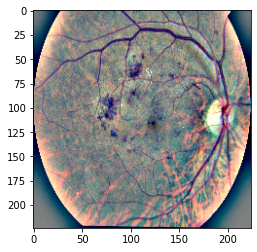

In [73]:
plt.imshow(openBenImg('/kaggle/working/ben/45.png'))

In [74]:
#model 

densenet2 = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(WIDTH, HEIGHT,3)
)

In [75]:
def build_model():
    model = Sequential()
    model.add(densenet2)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [76]:
model2 = build_model()
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


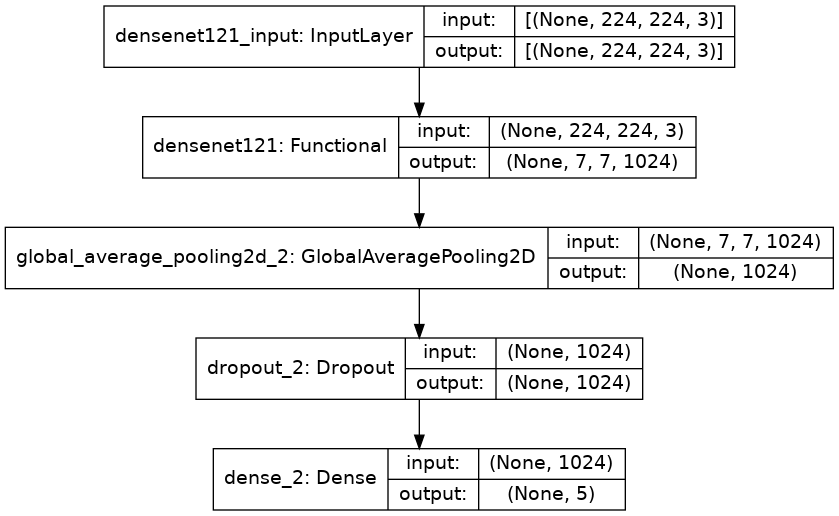

In [77]:
import pydot
from keras.utils.vis_utils import plot_model

plot_model(model2, to_file='/kaggle/working/model_plot2.png', show_shapes=True, show_layer_names=True)


In [78]:
class RetinaGenerator2():
    def __init__(self, image_df, batch_size, train=True):
        self.image_df = image_df
        self.batch_size = batch_size
        self.train = train
        self.step_per_epoch = len(self.image_df) // self.batch_size
        self.step_per_pred = 1 + (len(self.image_df) - 1) // self.batch_size
    def getGenerator(self):
        while True:
            for idx in range(self.step_per_epoch):
                batch_x = np.array([openBenImg(row.path) for row in self.image_df[idx * self.batch_size:(idx + 1) * self.batch_size].itertuples()])
                batch_y_cat= to_categorical([row.diagnosis for row in self.image_df[idx * self.batch_size:(idx + 1) * self.batch_size].itertuples()], num_classes=5)
                batch_y = np.empty(batch_y_cat.shape, dtype=batch_y_cat.dtype)
                batch_y[:, 4] = batch_y_cat[:, 4]
                for i in range(3, -1, -1):
                    batch_y[:, i] = np.logical_or(batch_y_cat[:, i], batch_y[:, i+1])
                yield batch_x, batch_y
    def getInputGenerator(self):
        for idx in range(self.step_per_pred + 1):
            yield np.array([openBenImg(row.path) for row in self.image_df[idx * self.batch_size:min((idx + 1) * self.batch_size, len(self.image_df))].itertuples()])


In [84]:
BATCH_SIZE = 32
LEARNING_RATE = 0.005
EPOCHS = 20
PATIENCE = 3
LR_PATIENCE =3
VALIDATION_GENERATOR = RetinaGenerator2(val_df, BATCH_SIZE)
TRAINING_GENERATOR = RetinaGenerator2(train_df, BATCH_SIZE)
ALL_GENERATOR = RetinaGenerator2(df_train_new, BATCH_SIZE)
STEPS_PER_EPOCH = TRAINING_GENERATOR.step_per_epoch
VALIDATION_STEPS = VALIDATION_GENERATOR.step_per_epoch

In [85]:
print(train_df.shape, val_df.shape, test_df.shape)

(2343, 4) (586, 4) (733, 4)


In [87]:
Callbacks=[EarlyStopping(patience=PATIENCE, restore_best_weights=True), 
           ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)]
with tf.device('/device:GPU:0'):
    H2 = model2.fit_generator(generator=TRAINING_GENERATOR.getGenerator(),
                            validation_data=VALIDATION_GENERATOR.getGenerator(),
                            steps_per_epoch=STEPS_PER_EPOCH,
                            validation_steps=VALIDATION_STEPS,
                            epochs=EPOCHS,
                            callbacks=Callbacks,
                            verbose=1)

Epoch 1/20
73/73 [==============================] - 28s 235ms/step - loss: 0.5416 - accuracy: 0.3845 - val_loss: 0.2722 - val_accuracy: 0.6997
Epoch 2/20
73/73 [==============================] - 15s 210ms/step - loss: 0.2182 - accuracy: 0.5876 - val_loss: 0.1837 - val_accuracy: 0.5833
Epoch 3/20
73/73 [==============================] - 15s 211ms/step - loss: 0.1450 - accuracy: 0.6136 - val_loss: 0.1484 - val_accuracy: 0.5556
Epoch 4/20
73/73 [==============================] - 15s 208ms/step - loss: 0.1063 - accuracy: 0.6285 - val_loss: 0.1307 - val_accuracy: 0.5625
Epoch 5/20
73/73 [==============================] - 16s 213ms/step - loss: 0.0695 - accuracy: 0.6214 - val_loss: 0.1213 - val_accuracy: 0.6076
Epoch 6/20
73/73 [==============================] - 15s 209ms/step - loss: 0.0485 - accuracy: 0.6058 - val_loss: 0.1215 - val_accuracy: 0.5799
Epoch 7/20
73/73 [==============================] - 16s 213ms/step - loss: 0.0354 - accuracy: 0.5892 - val_loss: 0.1319 - val_accuracy: 0.5556

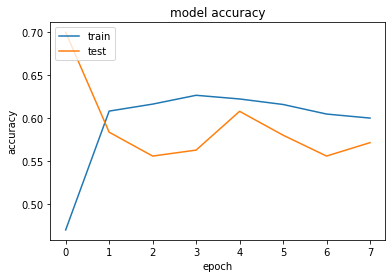

In [88]:
plt.plot(H2.history['accuracy'])
plt.plot(H2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

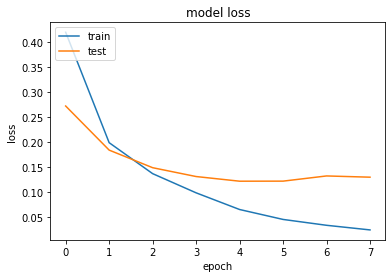

In [89]:
# summarize history for loss
plt.plot(H2.history['loss'])
plt.plot(H2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [94]:
from sklearn.metrics import accuracy_score, cohen_kappa_score
VERBOSE = 1
if VERBOSE:
    TEST_GENERATOR = RetinaGenerator2(test_df, BATCH_SIZE)
    STEPS = TEST_GENERATOR.step_per_pred
    Y_pred = (model2.predict_generator(TEST_GENERATOR.getInputGenerator(), steps=STEPS) > 0.5).sum(axis=1) - 1
    Y_test = np.array(test_df.diagnosis)
    print("Average absolute distance is: {:.2f}".format(np.abs(Y_pred - Y_test).mean()))
    display(confusion_matrix(Y_test, Y_pred))
    print("Accuracy Score:" + str(accuracy_score(Y_test, Y_pred)))
    print("Cohen Kappa Score:" + str(cohen_kappa_score(Y_test, Y_pred, weights='quadratic')))

Average absolute distance is: 0.24


array([[364,   3,   1,   0,   0],
       [  8,  30,  23,   2,   0],
       [  7,  14, 164,  11,   3],
       [  0,   1,  14,  24,   3],
       [  0,   1,  23,  23,  14]])

Accuracy Score:0.8130968622100955
Cohen Kappa Score:0.8887463330068514


In [95]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       368
           1       0.61      0.48      0.54        63
           2       0.73      0.82      0.77       199
           3       0.40      0.57      0.47        42
           4       0.70      0.23      0.35        61

    accuracy                           0.81       733
   macro avg       0.68      0.62      0.62       733
weighted avg       0.81      0.81      0.80       733



In [96]:
model2.save('model2-nodataaugm-benblend.h5')